In [5]:
import pandas as pd

class FootballTeamStats:
    def __init__(self, possession_percentage, shots_on_target, key_passes, goals):
        """
        Initialize with key team statistics.

        :param possession_percentage: Possession as a percentage (0 to 100)
        :param shots_on_target: Number of shots on target
        :param key_passes: Number of key passes leading to potential scoring opportunities
        :param goals: Number of goals scored
        """
        self.possession_percentage = possession_percentage
        self.shots_on_target = shots_on_target
        self.key_passes = key_passes
        self.goals = goals

    def calculate_hpus(self):
        """
        Calculate the Holistic Possession Utilization Score (HPUS).

        The formula considers possession efficiency, shot accuracy, and key plays.

        :return: HPUS value as a float
        """
        # Weighting factors for different components
        possession_weight = 0.4
        shots_weight = 0.2
        key_passes_weight = 0.2
        goals_weight = 0.2

        # Normalize the stats
        normalized_possession = self.possession_percentage / 100
        normalized_shots = min(self.shots_on_target / 10, 1)  # Assuming max impactful shots is 10
        normalized_key_passes = min(self.key_passes / 15, 1)  # Assuming max impactful key passes is 15
        normalized_goals = min(self.goals / 5, 1)  # Assuming max impactful goals is 5

        # Calculate HPUS
        hpus = (
            (normalized_possession * possession_weight) +
            (normalized_shots * shots_weight) +
            (normalized_key_passes * key_passes_weight) +
            (normalized_goals * goals_weight)
        )

        return round(hpus * 100, 2)  # Return HPUS as a percentage


# Example Usage with CSV Data
def calculate_possession(data):
    """
    Calculate possession as the percentage of events involving each contestant.

    :param data: DataFrame containing match events
    :return: possession percentage for the team (assuming two contestants)
    """
    total_events = len(data)
    if total_events == 0:
        return 0

    team_events = data[data['contestantId'].notna()]
    possession_percentage = (len(team_events) / total_events) * 100
    return possession_percentage


def calculate_key_passes(data):
    """
    Calculate the total key passes, including through-balls, assists, and second assists.

    :param data: DataFrame containing match events
    :return: Total key passes count
    """
    type_cols = [col for col in data.columns if '/qualifierId' in col]

    data['endX'] = 0.0
    data['endY'] = 0.0
    for i in range(len(data)):
        df1 = data.iloc[i:i + 1, :]
        for j in range(len(type_cols)):
            col = df1[type_cols[j]].values[0]
            if col == 140:
                endx = df1.loc[:, 'qualifier/%i/value' % j].values[0]
                data.at[i, 'endX'] = endx
            if col == 141:
                endy = df1.loc[:, 'qualifier/%i/value' % j].values[0]
                data.at[i, 'endY'] = endy

    data['Through-ball'] = 0
    for i in range(len(data)):
        df1 = data.iloc[i:i + 1, :]
        for j in range(len(type_cols)):
            col = df1[type_cols[j]].values[0]
            if col == 4:
                data.at[i, 'Through-ball'] = 1

    data['Assist'] = 0
    for i in range(len(data)):
        df1 = data.iloc[i:i + 1, :]
        for j in range(len(type_cols)):
            col = df1[type_cols[j]].values[0]
            if col == 210:
                data.at[i, 'Assist'] = 1

    data['2nd Assist'] = 0
    for i in range(len(data)):
        df1 = data.iloc[i:i + 1, :]
        for j in range(len(type_cols)):
            col = df1[type_cols[j]].values[0]
            if col == 218:
                data.at[i, '2nd Assist'] = 1

    # Sum key passes across all categories
    data['KeyPass'] = data['Through-ball'] + data['Assist'] + data['2nd Assist']
    total_key_passes = data['KeyPass'].sum()
    return total_key_passes


def main():
    # Load match statistics from CSV file
    file_path = "/Users/marclambertes/Python/Matches/Men/2024-2025/Scotland 2024-2025/Rangers 4-0 Ross County.csv"
    data = pd.read_csv(file_path)

    # Assuming the CSV has columns: 'typeId', 'contestantId'
    possession_percentage = calculate_possession(data)
    shots_on_target = len(data[data['typeId'] == 15])  # Shots on target events
    key_passes = calculate_key_passes(data)
    goals = len(data[data['typeId'] == 16])  # Goal events

    team_stats = FootballTeamStats(
        possession_percentage, shots_on_target, key_passes, goals
    )
    hpus_score = team_stats.calculate_hpus()
    print(f"Holistic Possession Utilization Score (HPUS): {hpus_score}%")


if __name__ == "__main__":
    main()


Holistic Possession Utilization Score (HPUS): 96.0%


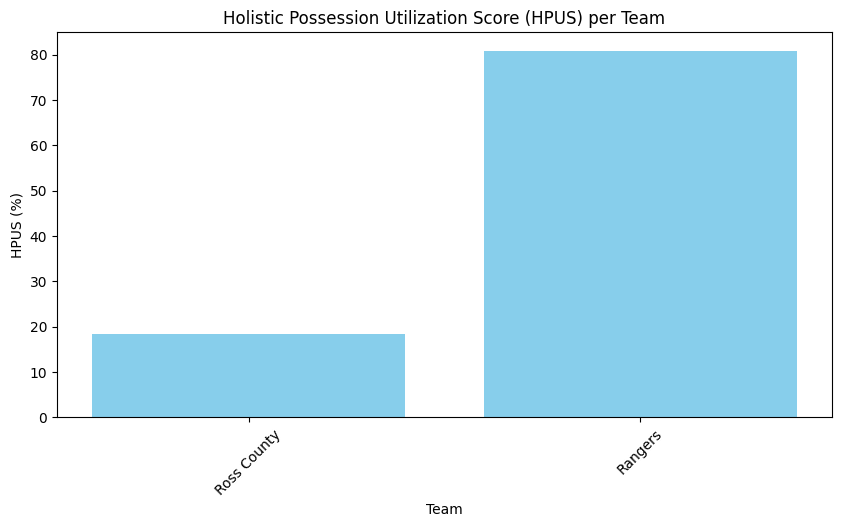

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the team mapping file
mapping_file_path = '/Users/marclambertes/Downloads/opta_club_rankings_19012025.xlsx'  # Replace with your mapping file path
mapping_df = pd.read_excel(mapping_file_path)  # Assuming it has columns 'id' and 'team'

# Create a dictionary to map 'id' to 'team'
id_to_team = dict(zip(mapping_df['id'], mapping_df['team']))

class FootballTeamStats:
    def __init__(self, possession_percentage, shots_on_target, key_passes, goals):
        self.possession_percentage = possession_percentage
        self.shots_on_target = shots_on_target
        self.key_passes = key_passes
        self.goals = goals

    def calculate_hpus(self):
        possession_weight = 0.4
        shots_weight = 0.2
        key_passes_weight = 0.2
        goals_weight = 0.2

        normalized_possession = self.possession_percentage / 100
        normalized_shots = min(self.shots_on_target / 10, 1)
        normalized_key_passes = min(self.key_passes / 15, 1)
        normalized_goals = min(self.goals / 5, 1)

        hpus = (
            (normalized_possession * possession_weight) +
            (normalized_shots * shots_weight) +
            (normalized_key_passes * key_passes_weight) +
            (normalized_goals * goals_weight)
        )
        return round(hpus * 100, 2)

def calculate_key_passes(data):
    type_cols = [col for col in data.columns if '/qualifierId' in col]
    data['KeyPass'] = 0
    for i in range(len(data)):
        df1 = data.iloc[i:i + 1, :]
        for j in range(len(type_cols)):
            col = df1[type_cols[j]].values[0]
            if col in [4, 210, 218]:  # Through-ball, Assist, 2nd Assist
                data.at[i, 'KeyPass'] = 1
                break
    return data['KeyPass'].sum()

def calculate_possession(data):
    total_events = len(data)
    if total_events == 0:
        return 0
    team_events = data[data['contestantId'].notna()]
    possession_percentage = (len(team_events) / total_events) * 100
    return possession_percentage

def visualize_hpus(data):
    results = []
    for contestant_id, group in data.groupby('contestantId'):
        possession_percentage = (len(group) / len(data)) * 100
        shots_on_target = len(group[group['typeId'] == 15])
        key_passes = calculate_key_passes(group)
        goals = len(group[group['typeId'] == 16])

        stats = FootballTeamStats(possession_percentage, shots_on_target, key_passes, goals)
        hpus_score = stats.calculate_hpus()
        results.append((contestant_id, hpus_score))

    # Create a DataFrame from the results
    df_results = pd.DataFrame(results, columns=['contestantId', 'HPUS'])

    # Map contestantId to team name
    df_results['Team'] = df_results['contestantId'].map(id_to_team)

    # Plot the results with team names
    plt.figure(figsize=(10, 5))
    plt.bar(df_results['Team'], df_results['HPUS'], color='skyblue')
    plt.title('Holistic Possession Utilization Score (HPUS) per Team')
    plt.xlabel('Team')
    plt.ylabel('HPUS (%)')
    plt.xticks(rotation=45)
    plt.show()

def main():
    # Load your file
    file_path = "/Users/marclambertes/Python/Matches/Men/2024-2025/Scotland 2024-2025/Rangers 4-0 Ross County.csv"
    data = pd.read_csv(file_path)

    # Visualize HPUS per contestantId
    visualize_hpus(data)

if __name__ == "__main__":
    main()
